In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
import natsort
import GrowthAssayPlotlib

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [2]:
df1 = pd.read_json('GA1_df_melted.json')
df2 = pd.read_json('GA2_df_melted.json')
df3 = pd.read_json('GA3_df_melted.json')

df1['Repeat'] = '1'
df2['Repeat'] = '2'
df3['Repeat'] = '3'

hematocrit_levels = ['2%', '4%', '8%']

df = pd.concat([
    df1, 
    df2, 
    df3
    ])
df['Hematocrit'] = df['Hematocrit'].fillna('4%')
df['Plate'] = df['Plate'].fillna('6-well')
df

,Line,Speed,Repeat,Strain,Clone,Invasion rate,Parasitemia,Plate number,Well position,Hematocrit,Plate
0,Barseq,90-rpm,1,Barseq,,4.330311,0.282000,NaN,NaN,4%,6-well
1,Barseq,90-rpm,1,Barseq,,3.680021,0.205333,NaN,NaN,4%,6-well
2,Barseq,90-rpm,1,Barseq,,4.633576,0.492333,NaN,NaN,4%,6-well
3,Barseq,90-rpm,1,Barseq,,5.030241,0.519000,NaN,NaN,4%,6-well
4,Barseq,90-rpm,1,Barseq,,5.571967,0.594000,NaN,NaN,4%,6-well
...,...,...,...,...,...,...,...,...,...,...,...
564,NF54,180-rpm,3,NF54,,3.469799,0.298000,85.0,H1,4%,96-well
566,NF54,180-rpm,3,NF54,,3.930769,0.650000,87.0,H3,4%,96-well
568,NF54,180-rpm,3,NF54,,3.180212,0.566000,89.0,H5,4%,96-well
571,NF54,180-rpm,3,NF54,,5.624413,0.852000,92.0,H8,4%,50ml flask


3D7 49
Dd2 38
NF54 135


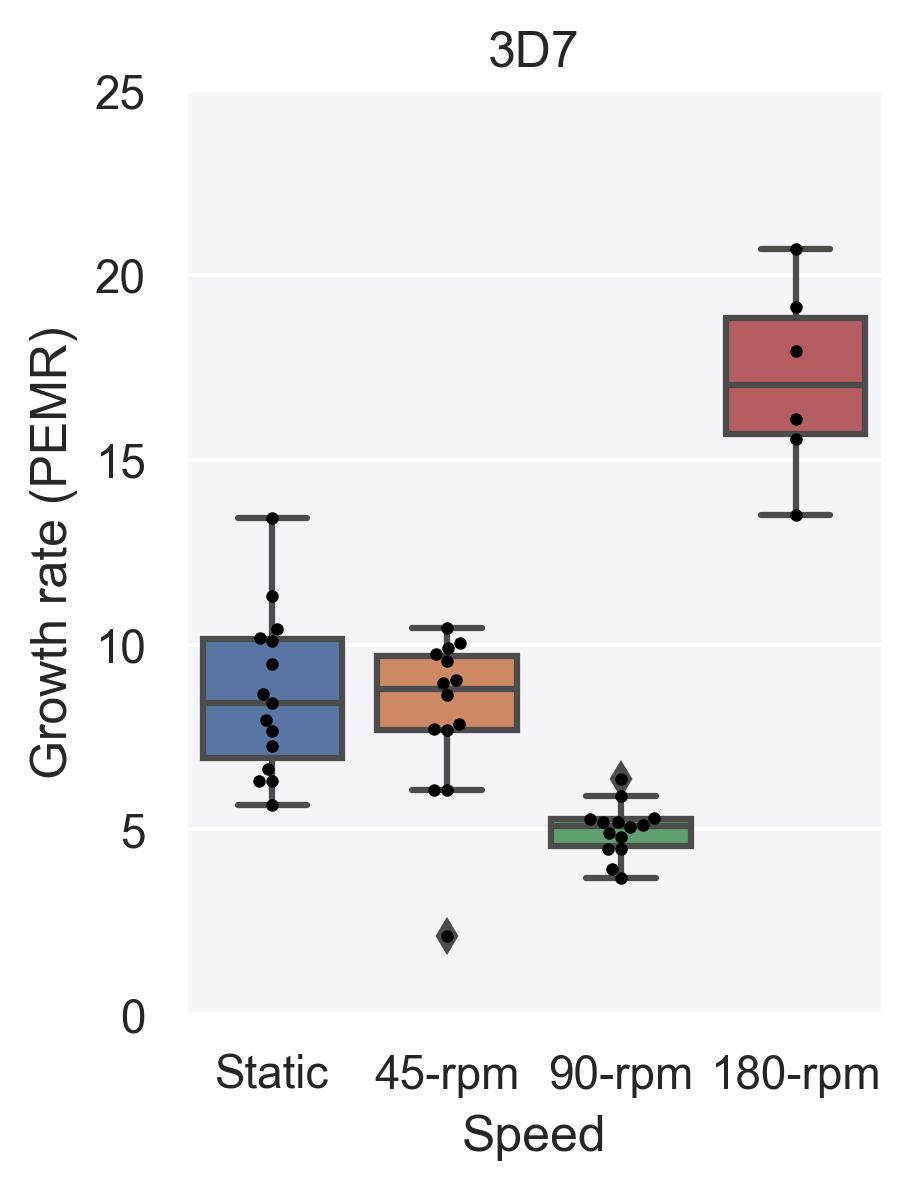

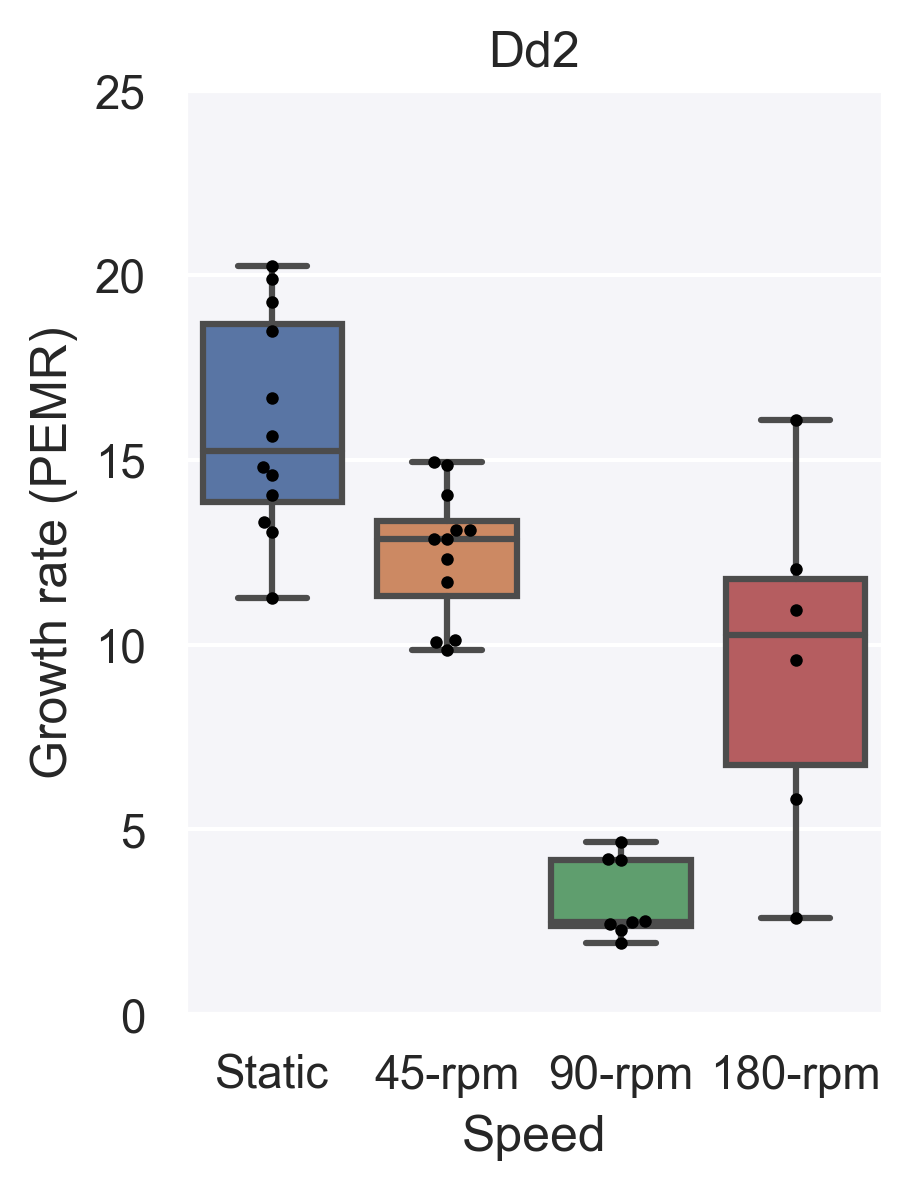

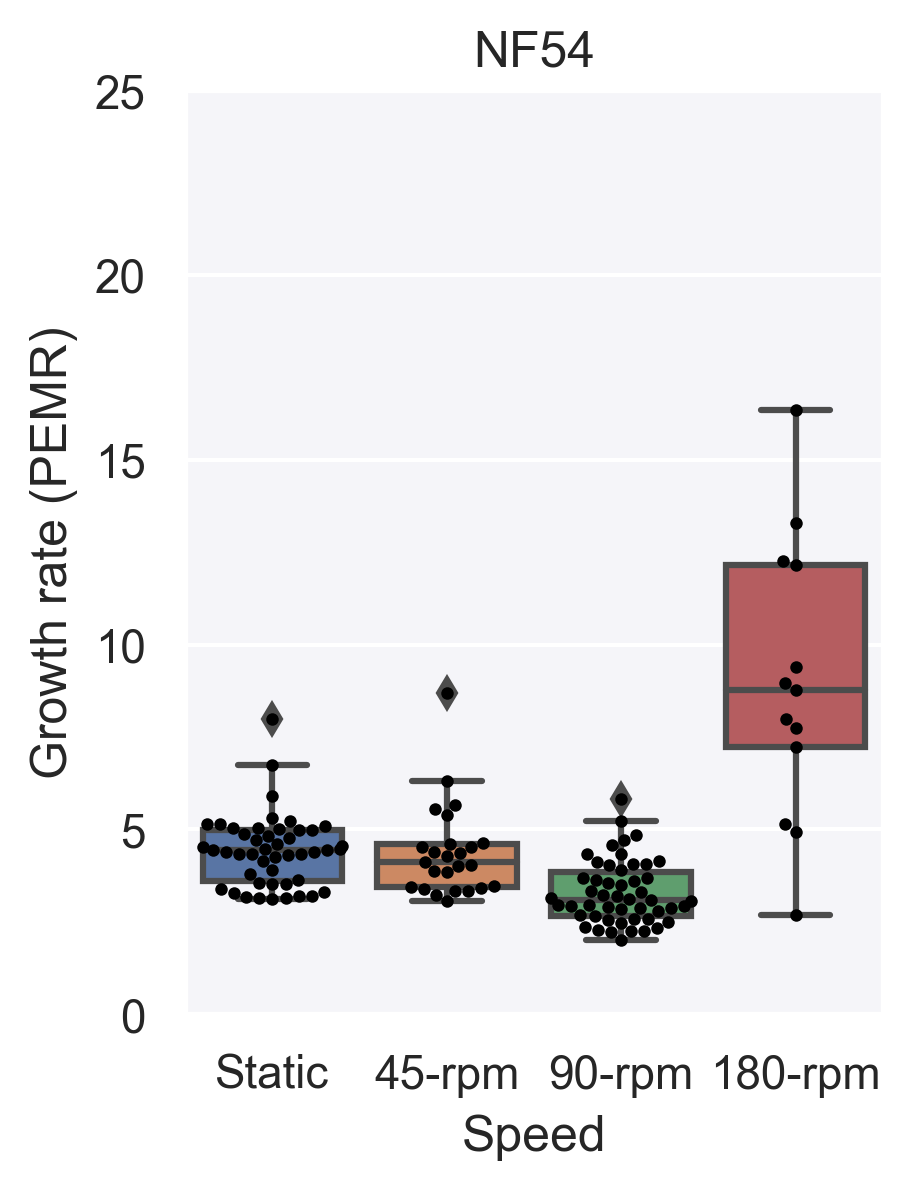

In [3]:
filter_lines = ['NF54', 'Dd2', '3D7']
dfq = df.query(f'Plate == "6-well" and Hematocrit == "4%" and Strain == @filter_lines' )
# dfq = df.query(f'Plate == "6-well" and Hematocrit == "4%" and Strain == @filter_lines and Repeat == "3"' )

MAX_Y = 25


sns.set_theme(#context='notebook', 
            #style='ticks', 
            style='darkgrid', 
            font='arial', 
            font_scale=1) 
            #   color_codes=True, 
            #   rc=None)
sns.set_style(rc = {'axes.facecolor': '#F5F5F9'})

for strain, dfg in dfq.groupby('Strain'):
    print(strain, len(dfg.index))

    plt.figure(figsize=(3,4), dpi=300)
    sns.boxplot(x='Speed', 
                y='Invasion rate', 
                data=dfg, 
                order=GrowthAssayPlotlib.speed_order, 
                #hue='Repeat', # This plots repeats separate for NF54
                #palette='rocket'
                )
    sns.swarmplot(x='Speed', 
                  y='Invasion rate', 
                  data=dfg, order=GrowthAssayPlotlib.speed_order, 
                  #hue='Repeat', 
                  dodge=True, 
                  color='black', 
                  size=3
                  )
    plt.title(strain)
    plt.ylim((0, MAX_Y))
    #plt.ylim((0, 12.5))
    plt.ylabel(GrowthAssayPlotlib.YLABEL)

    plt.rcParams['svg.fonttype'] = 'none'
    plt.savefig(f'Graphs all/Lines over different speeds {strain}.svg', bbox_inches='tight')
    # plt.close()

In [4]:

GrowthAssayPlotlib.significance_testing(
    df=dfq, 
    group_keys=['Strain', 'Speed', 'Repeat'],
    line_key='Strain',
    wildtype='NF54',
)




Testing Strain for 180-rpm, 2.
   - NF54 and 3D7         : ttest p-value = 0.0091, significant
Testing Strain for 180-rpm, 3.
   - NF54 and Dd2         : ttest p-value = 0.1917, not
Testing Strain for 45-rpm, 2.
   - NF54 and 3D7         : ttest p-value = 0.0000, significant
Testing Strain for 45-rpm, 3.
   - NF54 and Dd2         : ttest p-value = 0.0000, significant
Only one value of Strain for 90-rpm, 1
Testing Strain for 90-rpm, 1.
Testing Strain for 90-rpm, 2.
   - NF54 and 3D7         : ttest p-value = 0.0000, significant
Testing Strain for 90-rpm, 3.
   - NF54 and Dd2         : ttest p-value = 0.3457, not
Only one value of Strain for Static, 1
Testing Strain for Static, 1.
Testing Strain for Static, 2.
   - NF54 and 3D7         : ttest p-value = 0.0000, significant
Testing Strain for Static, 3.
   - NF54 and Dd2         : ttest p-value = 0.0000, significant

Testing Speed for 3D7, 2.
   - Static   and 90-rpm  : ttest p-value = 0.0000, significant
   - Static   and 45-rpm  : ttes

In [21]:

dfq = df.query(f'Plate == "6-well" and Hematocrit == "4%" and Strain == @filter_lines' )

def sem(data):
    return np.std(data, ddof=1) / np.sqrt(np.size(data))

for (Speed, Strain, Repeat), dfg in dfq.groupby(['Speed','Strain','Repeat']):
    data = dfg['Invasion rate']
    print(f'{Strain}, {Speed}, {Repeat}, {np.mean(data):.2f}, {sem(data):.2f}')

# for (Speed, Strain), dfg in dfq.groupby(['Speed','Strain']):
#     data = dfg['Invasion rate']
#     print(f'{Strain}, {Speed} {np.mean(data):.2f}, {sem(data):.2f}')

print(filter_lines)
df['Strain'].unique()


3D7, 180-rpm, 2, 17.16, 1.07
Dd2, 180-rpm, 3, 9.51, 1.94
NF54, 180-rpm, 2, 11.71, 1.31
NF54, 180-rpm, 3, 6.66, 0.92
3D7, 45-rpm, 2, 8.13, 0.59
Dd2, 45-rpm, 3, 12.49, 0.51
NF54, 45-rpm, 2, 4.53, 0.40
NF54, 45-rpm, 3, 4.19, 0.24
3D7, 90-rpm, 2, 4.98, 0.19
Dd2, 90-rpm, 3, 3.08, 0.38
NF54, 90-rpm, 1, 3.76, 0.22
NF54, 90-rpm, 2, 3.39, 0.17
NF54, 90-rpm, 3, 2.77, 0.10
3D7, Static, 2, 8.65, 0.56
Dd2, Static, 3, 15.94, 0.85
NF54, Static, 1, 4.52, 0.26
NF54, Static, 2, 4.24, 0.12
NF54, Static, 3, 4.77, 0.44
['NF54', 'Dd2', '3D7']


array(['Barseq', 'KOEBA140', 'KOEBA175', 'KOEBA181', 'KOP230P', 'KOPfs25',
       'KORH1', 'KORH2a', 'KORH4', 'NF54', '3D7', 'Dd2'], dtype=object)

In [6]:
# df2_melted_q = df_hem.query('Hematocrit != ["2%", "8%"]').copy()
# df2_melted_q['Line']  = df2_melted_q['Line simple']

# df3_melted_q = df3_melted.query('Plate == "6-well"').copy()

# df2_melted_q['Line'] = df2_melted_q['Line'] + ' GA2'
# df3_melted_q['Line'] = df3_melted_q['Line'] + ' GA3'

# df_merged = pd.concat([df2_melted_q, df3_melted_q], ignore_index=True)

# print(df_merged['Line'].unique())

# line_order_filter = [
#     'Dd2 GA3', 
#     '3D7 GA2', 
#     'NF54 GA2', 
#     'NF54 GA3',
#     'KOEBA175 C6 GA2', 
#     # 'KOEBA175 3D7 GA2', 
#     # 'KOEBA175 C1 GA2',
#     # 'KOEBA175 C2 GA2', 
#     # 'KOEBA175 mix GA2',
# ]

# dfq = df_merged.query('Line == @line_order_filter')

# plt.figure(figsize=(6,4), dpi=300)
# sns.boxplot(x='Speed', order=speed_order, y='Invasion rate', data=dfq, hue='Line', hue_order=line_order_filter, palette='rocket')
# sns.swarmplot(x='Speed', order=speed_order, y='Invasion rate', data=dfq, hue='Line', hue_order=line_order_filter, color='black', dodge=True, size=5, legend=False)
# plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# plt.title(f'')
# plt.ylim((0,MAX_INVASION_RATE_PLOT))
# plt.savefig(os.path.join(output_folder_ga3, f'Comparison line.{EXTENSION}'), bbox_inches='tight')
# plt.close()

180-rpm -7.127568991944551 11.25452295881796 -0.40255434122692724 0.022359948925049795 2.9591388321435557
45-rpm -0.9096691566148752 4.4784882926008835 -0.11318720468707479 0.46987989204018854 1.2470799159019756
90-rpm 2.2756019417125217 1.769956208649559 0.33668497822520377 0.004673559041792844 0.7775164824579407
Static -2.531976390798328 5.7834053876691645 -0.42277405681165153 0.0006879790734640144 0.7065879169510486


Text(0, 0.5, 'Invasion rate')

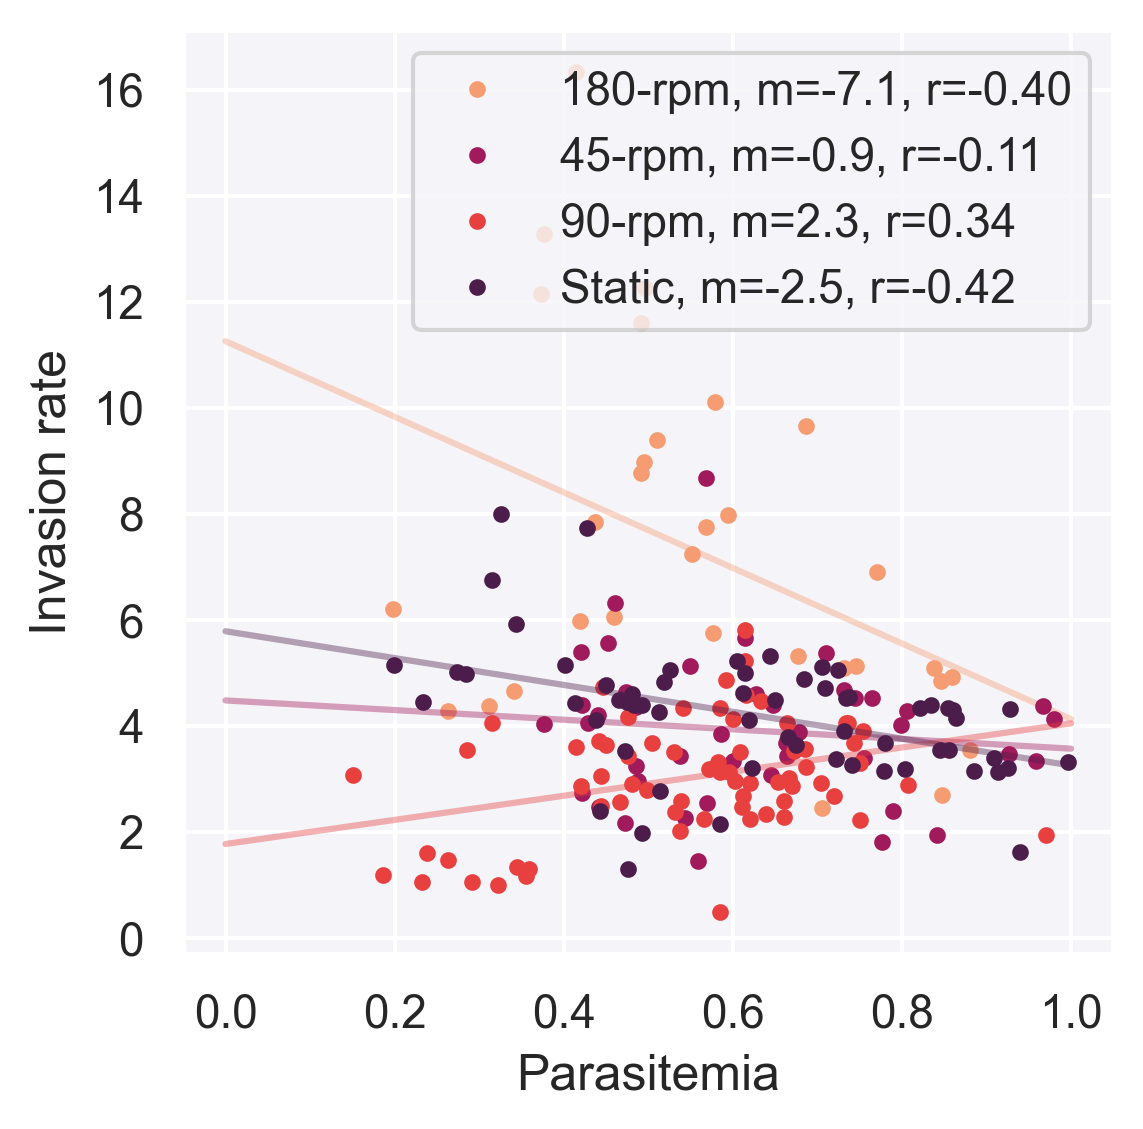

In [7]:
from scipy.stats import linregress

dfq = df.query('Strain == "NF54" and Plate == "6-well"')

# sns.lmplot(
#     data=dfq,
#     x='Parasitemia',
#     y='Invasion rate',
#     hue='Speed',
# )

# def fit_line_and_print_stats(x, y, **kwargs):
#     slope, intercept, r_value, p_value, std_err = linregress(x, y)
#     fit_line_eq = f'y = {slope:.2f}x + {intercept:.2f}'
#     r_squared = r_value**2
#     return slope, intercept, r_value, p_value, std
#     # Print equation and R-squared
#     print(f'Line Equation: {fit_line_eq}, R-squared: {r_squared:.4f}')

colors = sns.color_palette('rocket', n_colors=4)

color_map = {s:c for s, c in zip(GrowthAssayPlotlib.speed_order, colors)}

plt.figure(figsize=(4,4), dpi=300)
for speed, dfg in dfq.groupby('Speed'):
    c = color_map[speed]
    slope, intercept, r_value, p_value, std_err = linregress(dfg['Parasitemia'], dfg['Invasion rate'])
    plt.plot(
        dfg['Parasitemia'],
        dfg['Invasion rate'],
        '.',
        color=c,
        label=f'{speed}, m={slope:.1f}, r={r_value:.2f}',
    )
    xs = np.array([0,1])
    ys = slope * xs + intercept
    plt.plot(xs, ys, color=c, alpha=0.4)

    print(speed, slope, intercept, r_value, p_value, std_err)

plt.legend()
plt.xlabel('Parasitemia')
plt.ylabel('Invasion rate')